In [1]:
import numpy as np
import bagpy
from bagpy import bagreader
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import math
from evaluate_rosbag import resample

### Read all RosBags

In [2]:
bags = ['bag_1.bag', 'bag_2.bag', 'bag_3.bag', 'bag_4.bag']
bag_names = ['bag_1', 'bag_2', 'bag_3', 'bag_4']
df = {}

for idx, bag in enumerate(bags):
    bag_name =  bag_names[idx] 
    bag_ = bagreader(bag)

    msg_pose = bag_.message_by_topic('/qualisys/PAPER/pose')    
    msg_vel = bag_.message_by_topic('/qualisys/PAPER/velocity')
    msg_lh = bag_.message_by_topic('/car1/lighthouse')
    msg_imu = bag_.message_by_topic('/car1/imu')
    msg_we = bag_.message_by_topic('/car1/wheel_encoders')

    if(msg_pose is not None):
        df_name_pose = f'df_{bag_name}_pose'
        df[df_name_pose] = pd.read_csv(msg_pose)
    else:
        df_name_pose = f'df_{bag_name}_pose'
        df[df_name_pose] = None
    if(msg_vel is not None):
        df_name_vel = f'df_{bag_name}_vel'
        df[df_name_vel] = pd.read_csv(msg_vel)
    if(msg_lh is not None):
        df_name_lh = f'df_{bag_name}_lh'
        df[df_name_lh] = pd.read_csv(msg_lh) 
    else:
        df_name_pose = f'df_{bag_name}_lh'
        df[df_name_pose] = None
    if(msg_imu is not None):
        df_name_imu = f'df_{bag_name}_imu'
        df[df_name_imu] = pd.read_csv(msg_imu)    
    if(msg_we is not None):
        df_name_we = f'df_{bag_name}_we'
        df[df_name_we] = pd.read_csv(msg_we)   

[INFO]  Data folder bag_1 already exists. Not creating.
No data on the topic:/car1/lighthouse
[INFO]  Data folder bag_2 already exists. Not creating.
[INFO]  Data folder bag_3 already exists. Not creating.
No data on the topic:/car1/lighthouse
[INFO]  Data folder bag_4 already exists. Not creating.


### Compute Intitial States

In [3]:
start_time = 0
print('x_init, y_init, yaw_init')
print('------------------------------')
for idx, bag in enumerate(bags):
    df_name_pose = f'df_{bag_names[idx]}_pose'

    if df[df_name_pose] is not None:
        df_bag_pose = df[df_name_pose]
        df_bag_pose_ = df_bag_pose[df_bag_pose['Time'] >= df_bag_pose['Time'][0] +start_time]

        init_x = df_bag_pose_['pose.position.x'].iloc[0]
        init_y = df_bag_pose_['pose.position.y'].iloc[0]
        
        q_x = df_bag_pose_['pose.orientation.x'].iloc[0]
        q_y = df_bag_pose_['pose.orientation.y'].iloc[0]
        q_z = df_bag_pose_['pose.orientation.z'].iloc[0]
        q_w = df_bag_pose_['pose.orientation.w'].iloc[0]
        
        roll, pitch, yaw = R.from_quat([q_x, q_y, q_z, q_w]).as_euler("XYZ")
        print(f'{bag_names[idx]}: {init_x}, {init_y}, {yaw}')

x_init, y_init, yaw_init
------------------------------
bag_1: 0.1303467102050781, -0.7790528564453125, 0.5146543338795821
bag_2: -0.5020744018554687, -0.7155955200195312, 2.887633933749203
bag_3: -0.1515470123291015, -1.139797119140625, -0.48451811588813676
bag_4: -1.125078369140625, -0.1821446075439453, 1.8907097311433017


### Plot Trajectories

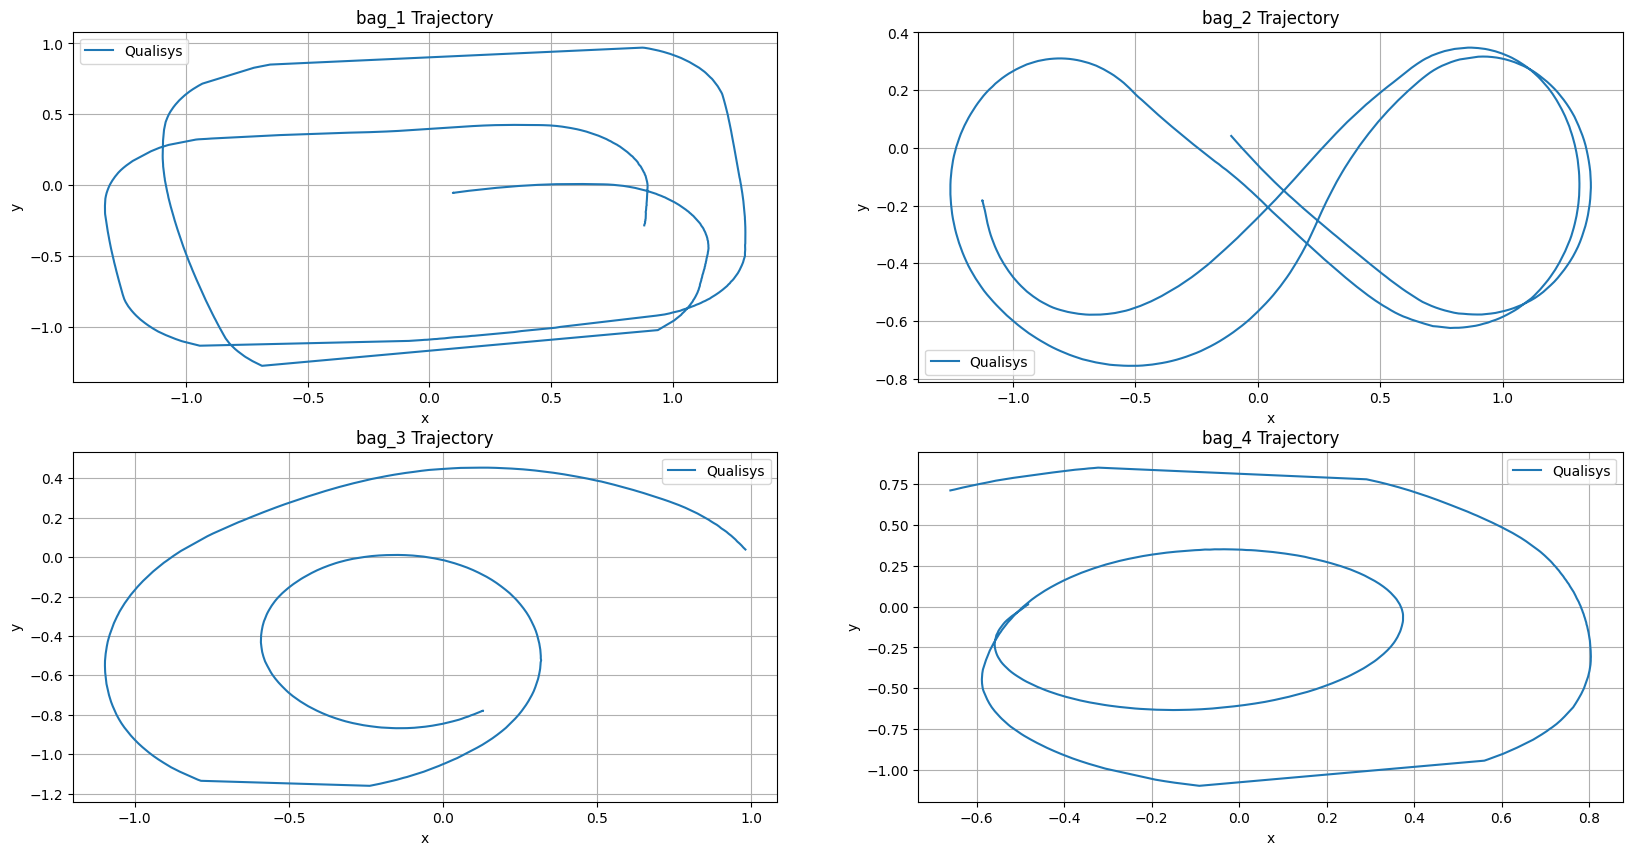

In [4]:
start_ts = 0
end_ts = 8000
starting_bag_at_ts = 9
col = 0
row = 0

fig, ax = plt.subplots(int(len(bags)/2),2)
fig.set_figheight(10)
fig.set_figwidth(20)

for idx, bag in enumerate(bags):
    
    df_name_pose = f'df_{bag_names[idx]}_pose'

    if df[df_name_pose] is not None:
        df_bag_pose = df[df_name_pose]
        df_bag_pose_ = df_bag_pose[df_bag_pose['Time'] >= df_bag_pose['Time'].min() + starting_bag_at_ts]
    
    if (df[df_name_vel] is not None) and (df[df_name_imu] is not None):
        ax[row, col].plot(df_bag_pose_['pose.position.x'][start_ts:end_ts], df_bag_pose_['pose.position.y'][start_ts:end_ts], label = "Qualisys")
    title = f'{bag_names[idx] } Trajectory'
    ax[row, col].title.set_text(title)
    ax[row, col].set_xlabel('x')
    ax[row, col].set_ylabel('y')
    ax[row, col].legend()
    ax[row, col].grid()
    
    if col == 1:
        row += 1
        col = 0
    else:
        col += 1

### Plot Sensor Data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


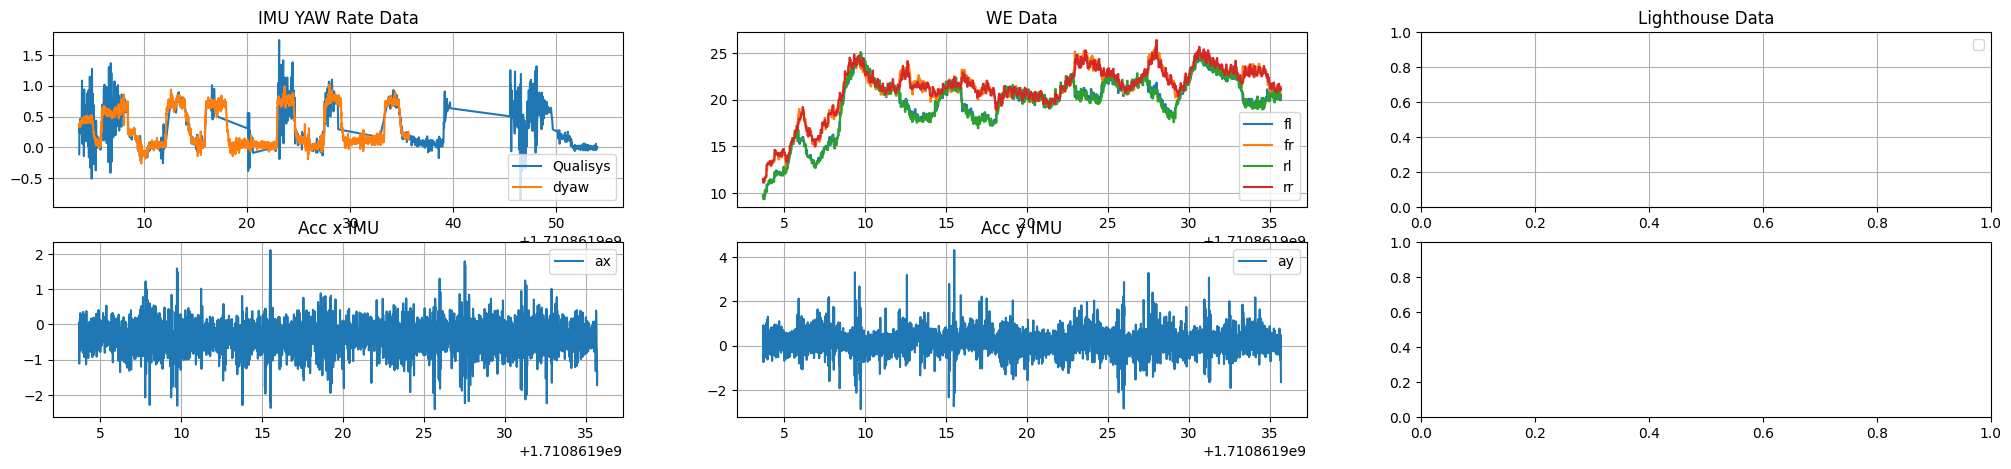

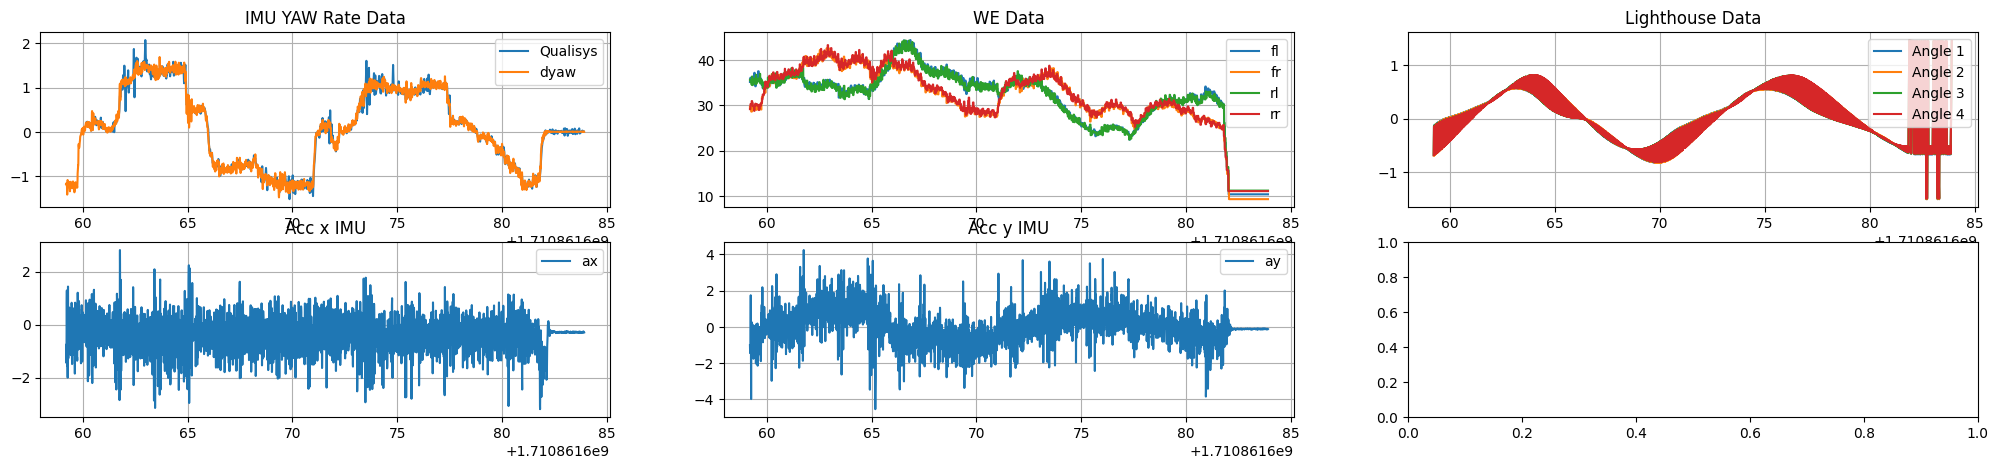

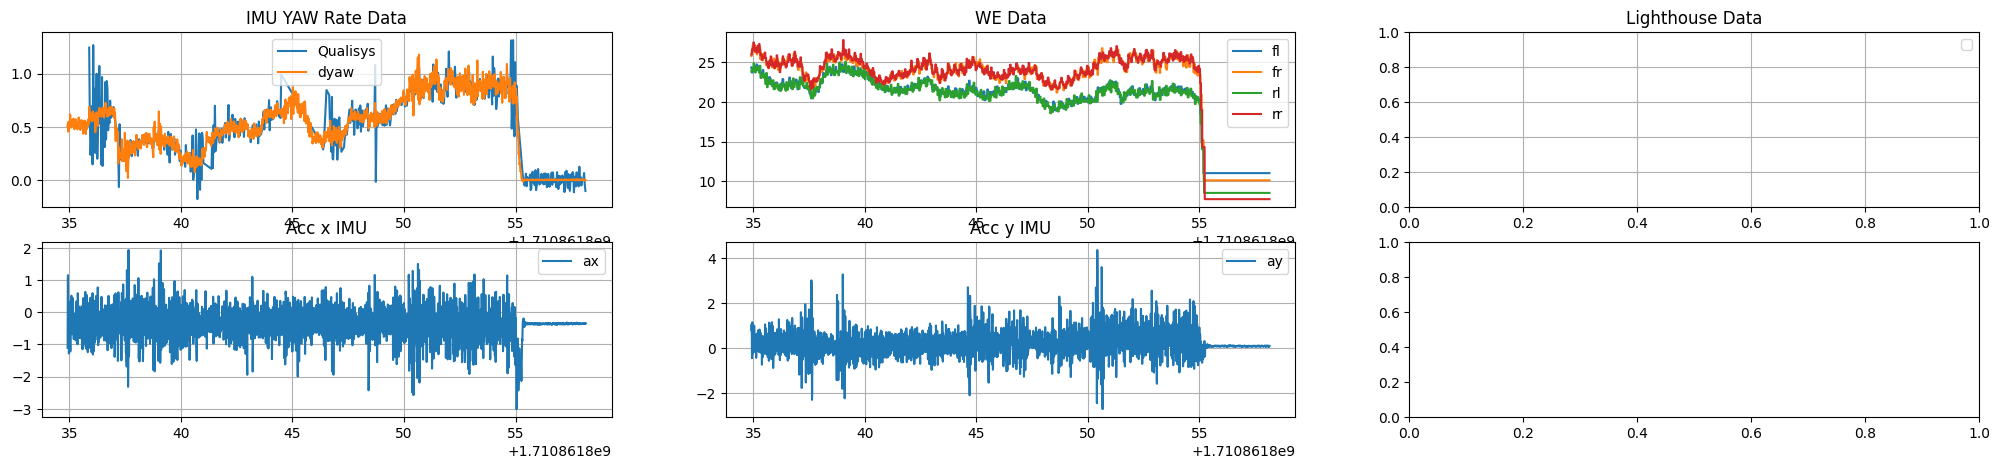

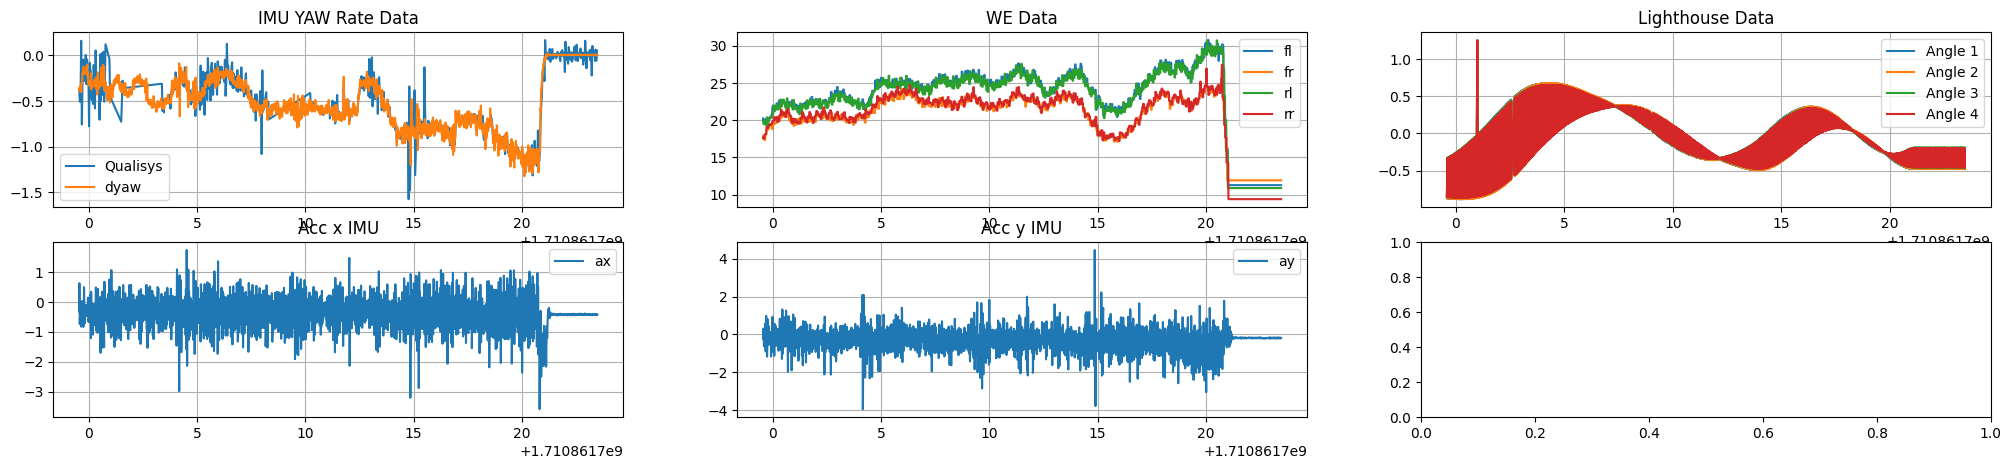

In [5]:
start_ts = 0
end_ts = 8000
starting_bag_at_ts = 9

for idx, bag in enumerate(bags):
    fig, ax = plt.subplots(2,3)
    fig.set_figheight(5)
    fig.set_figwidth(25)
    
    df_name_vel = f'df_{bag_names[idx]}_vel'
    df_name_lh = f'df_{bag_names[idx]}_lh'
    df_name_imu = f'df_{bag_names[idx]}_imu'
    df_name_we = f'df_{bag_names[idx]}_we'

    if df[df_name_vel] is not None:
        df_bag_vel = df[df_name_vel]
        df_bag_vel_ = df_bag_vel[df_bag_vel['Time'] >= df_bag_vel['Time'].min() + starting_bag_at_ts]
        
    if df[df_name_lh] is not None:
        df_bag_lh = df[df_name_lh]
        df_bag_lh_ = df_bag_lh[df_bag_lh['Time'] >= df_bag_lh['Time'].min() + starting_bag_at_ts]

    if df[df_name_imu] is not None:
        df_bag_imu = df[df_name_imu]
        df_bag_imu_ = df_bag_imu[df_bag_imu['Time'] >= df_bag_imu['Time'].min() + starting_bag_at_ts]

    if df[df_name_we] is not None:
        df_bag_we = df[df_name_we]
        df_bag_we_ = df_bag_we[df_bag_we['Time'] >= df_bag_we['Time'].min() + starting_bag_at_ts]
    

    if  (df[df_name_vel] is not None) and (df[df_name_imu] is not None):
        ax[0, 0].plot(df_bag_vel_['Time'][start_ts:end_ts], df_bag_vel_['twist.angular.z'][start_ts:end_ts], label = "Qualisys")
        ax[0, 0].plot(df_bag_imu_['Time'][start_ts:end_ts], df_bag_imu_['angular_velocity.z'][start_ts:end_ts], label = "dyaw") 
    ax[0, 0].title.set_text('IMU YAW Rate Data')
    ax[0, 0].legend()
    ax[0, 0].grid()

    if  df[df_name_we] is not None:
        ax[0, 1].plot(df_bag_we_['Time'][start_ts:end_ts], df_bag_we_['front_left'][start_ts:end_ts], label = "fl") 
        ax[0, 1].plot(df_bag_we_['Time'][start_ts:end_ts], df_bag_we_['front_right'][start_ts:end_ts], label = "fr") 
        ax[0, 1].plot(df_bag_we_['Time'][start_ts:end_ts], df_bag_we_['rear_left'][start_ts:end_ts], label = "rl") 
        ax[0, 1].plot(df_bag_we_['Time'][start_ts:end_ts], df_bag_we_['rear_right'][start_ts:end_ts], label = "rr") 
    ax[0, 1].title.set_text('WE Data')
    ax[0, 1].legend()
    ax[0, 1].grid()

    if  df[df_name_lh] is not None:
        ax[0, 2].plot(df_bag_lh_['Time'][start_ts:end_ts], df_bag_lh_['angle_0'][start_ts:end_ts], label = "Angle 1") 
        ax[0, 2].plot(df_bag_lh_['Time'][start_ts:end_ts], df_bag_lh_['angle_1'][start_ts:end_ts], label = "Angle 2") 
        ax[0, 2].plot(df_bag_lh_['Time'][start_ts:end_ts], df_bag_lh_['angle_2'][start_ts:end_ts], label = "Angle 3") 
        ax[0, 2].plot(df_bag_lh_['Time'][start_ts:end_ts], df_bag_lh_['angle_3'][start_ts:end_ts], label = "Angle 4") 
    ax[0, 2].title.set_text('Lighthouse Data')
    ax[0, 2].legend()
    ax[0, 2].grid()

    if  df[df_name_imu] is not None:
        ax[1, 0].plot(df_bag_imu_['Time'][start_ts:end_ts], df_bag_imu_['linear_acceleration.x'][start_ts:end_ts], label = "ax") 
    ax[1, 0].title.set_text('Acc x IMU')
    ax[1, 0].legend()
    ax[1, 0].grid()

    if  df[df_name_imu] is not None:
        ax[1, 1].plot(df_bag_imu_['Time'][start_ts:end_ts], df_bag_imu_['linear_acceleration.y'][start_ts:end_ts], label = "ay") 
    ax[1, 1].title.set_text('Acc y IMU')
    ax[1, 1].legend()
    ax[1, 1].grid()

### Subsample Data

In [6]:
Ts = 0.03 #33Hz
df_subsampled = {}

for idx, bag in enumerate(bags):
    
    valid_vel = np.nan
    valid_lh = np.nan
    valid_imu = np.nan
    valid_we = np.nan
    
    df_name_vel = f'df_{bag_names[idx]}_vel'
    df_name_lh = f'df_{bag_names[idx]}_lh'
    df_name_imu = f'df_{bag_names[idx]}_imu'
    df_name_we = f'df_{bag_names[idx]}_we'

    if df[df_name_vel] is not None:
        df_bag_vel = df[df_name_vel]
        df_bag_vel_ = df_bag_vel.drop(['header.frame_id'], axis=1)
        valid_vel = 1
        
    if df[df_name_lh] is not None:
        df_bag_lh = df[df_name_lh]
        df_bag_lh_ = df_bag_lh.drop(['header.frame_id'], axis=1)
        valid_lh = 1

    if df[df_name_imu] is not None:
        df_bag_imu = df[df_name_imu]
        df_bag_imu_ = df_bag_imu.drop(['header.frame_id'], axis=1)
        valid_imu = 1

    if df[df_name_we] is not None:
        df_bag_we = df[df_name_we]
        df_bag_we_ = df_bag_we.drop(['header.frame_id'], axis=1)
        valid_we = 1

    start_ts = np.nanmax([valid_imu * df_bag_imu['Time'].min(), valid_we * df_bag_we['Time'].min(), valid_vel * df_bag_vel['Time'].min(), valid_lh * df_bag_lh['Time'].min()])
    end_ts = np.nanmin([valid_imu * df_bag_imu['Time'].max(), valid_we * df_bag_we['Time'].max(), valid_vel * df_bag_vel['Time'].max(), valid_lh * df_bag_lh['Time'].max()])

    df_bag_imu_sub = resample(df_bag_imu_, Ts, start_ts, end_ts,  method="nearest")
    df_bag_vel_sub = resample(df_bag_vel_, Ts, start_ts, end_ts,  method="nearest")
    df_bag_we_sub = resample(df_bag_we_, Ts, start_ts, end_ts,  method="nearest")
    
    if valid_lh == 1:
        df_bag_lh_sub = resample(df_bag_lh_, Ts, start_ts, end_ts,  method="nearest")
        df_subsampled[df_name_lh] = df_bag_lh_sub
    else:
        df_subsampled[df_name_lh] = None

    print("subsampled ", bag_names[idx])

    df_subsampled[df_name_we] = df_bag_we_sub
    df_subsampled[df_name_imu] = df_bag_imu_sub
    df_subsampled[df_name_vel] = df_bag_vel_sub
    

subsampled  bag_1
subsampled  bag_2
subsampled  bag_3
subsampled  bag_4


### Compute std of Data

In [7]:
do_plot = False

for idx, bag in enumerate(bags):
    
    df_name_vel = f'df_{bag_names[idx]}_vel'
    df_name_lh = f'df_{bag_names[idx]}_lh'
    df_name_imu = f'df_{bag_names[idx]}_imu'
    df_name_we = f'df_{bag_names[idx]}_we'

    if df[df_name_vel] is not None:
        df_bag_vel_sub = df_subsampled[df_name_vel]
        df_bag_vel = df[df_name_vel]
        
    if df[df_name_lh] is not None:
        df_bag_lh_sub = df_subsampled[df_name_lh]
        df_bag_lh = df[df_name_lh]

    if df[df_name_imu] is not None:
        df_bag_imu_sub = df_subsampled[df_name_imu]
        df_bag_imu = df[df_name_imu]

    if df[df_name_we] is not None:
        df_bag_we_sub = df_subsampled[df_name_we]
        df_bag_we = df[df_name_we]
        
    imu_yaw_error = (df_bag_vel_sub["twist.angular.z"] - df_bag_imu_sub["angular_velocity.z"])
    imu_yaw_std = np.std(imu_yaw_error)**2
    print(bag_names[idx], " Standard deviation of imu yaw rate: ", imu_yaw_std)

    if do_plot:
        fig, ax = plt.subplots(1, 3)
        fig.set_figheight(5)
        fig.set_figwidth(25)
        
        # IMU Acc x
        ax[0].plot(np.linalg.norm(df_bag_imu[['linear_acceleration.x']].diff().to_numpy()[1500:5000], axis = 1))
        ax[0].grid()
        ax[0].legend()
        title = f'Difference in Acc x for {bag_names[idx]}'
        ax[0].title.set_text(title)
        # IMU Acc x
        ax[1].plot(np.linalg.norm(df_bag_imu[['linear_acceleration.y']].diff().to_numpy()[1500:5000], axis = 1))
        ax[1].grid()
        ax[1].legend()
        title = f'Difference in Acc y for {bag_names[idx]}'
        ax[1].title.set_text(title)
        # WHEEL ENCODERS
        ax[2].plot(np.linalg.norm(df_bag_we[['front_left', 'front_right', 'rear_left', 'rear_right']].diff().to_numpy()[1500:5000], axis = 1))
        ax[2].grid()
        ax[2].legend()
        title = f'Difference in Wheel encoder measurements for {bag_names[idx]}'
        ax[2].title.set_text(title)

bag_1  Standard deviation of imu yaw rate:  0.03155911547323677
bag_2  Standard deviation of imu yaw rate:  0.011345700122238522
bag_3  Standard deviation of imu yaw rate:  0.01846117423235087
bag_4  Standard deviation of imu yaw rate:  0.010741046884556474


### Plot Subsampled Data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


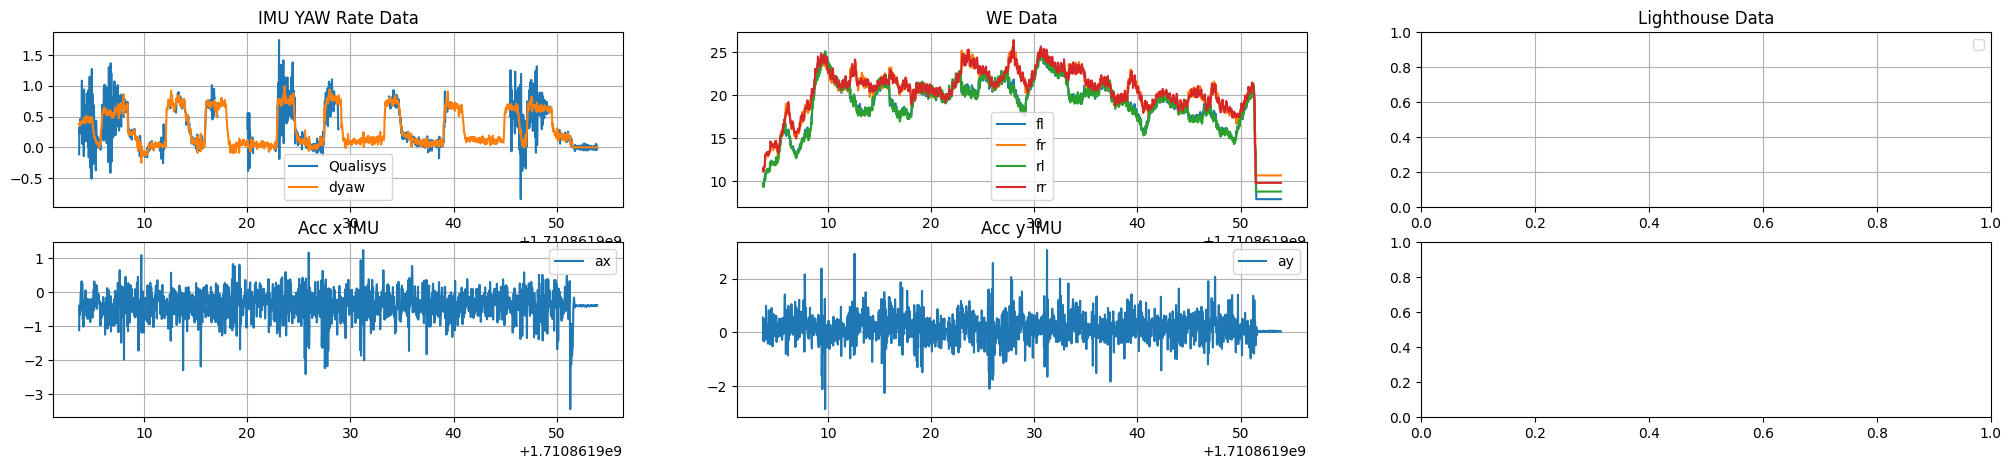

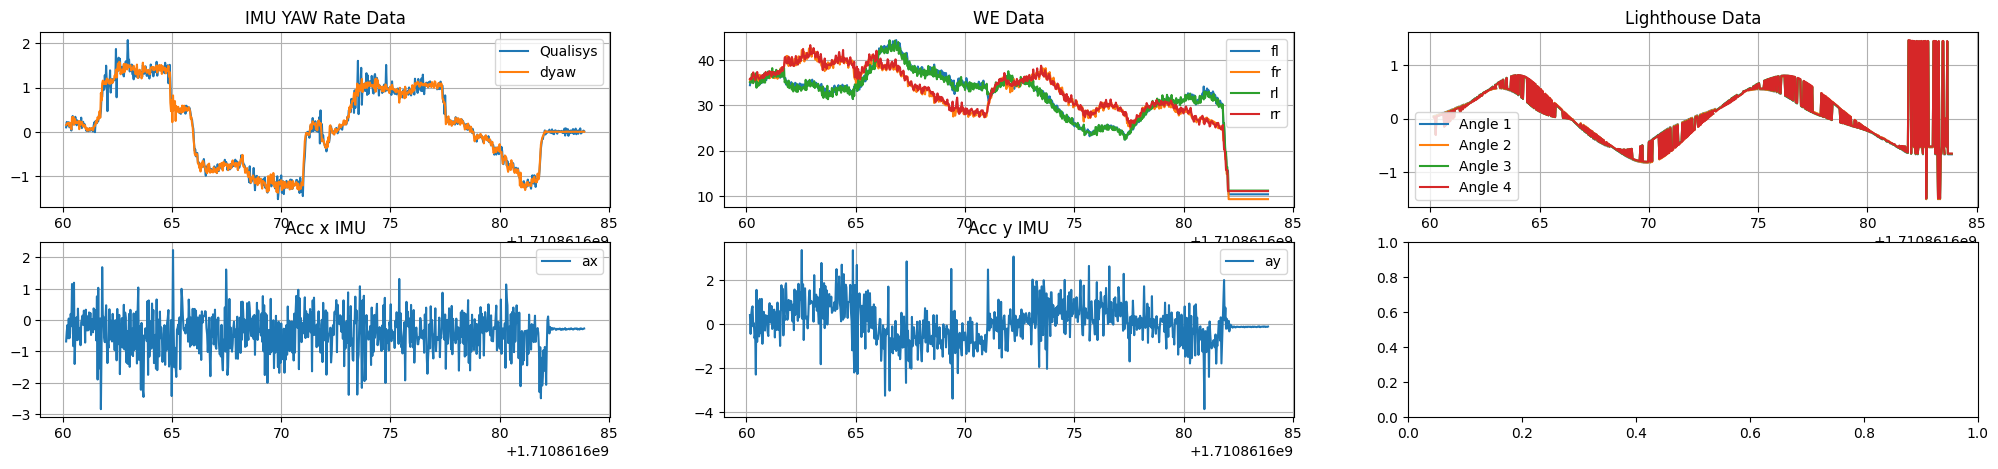

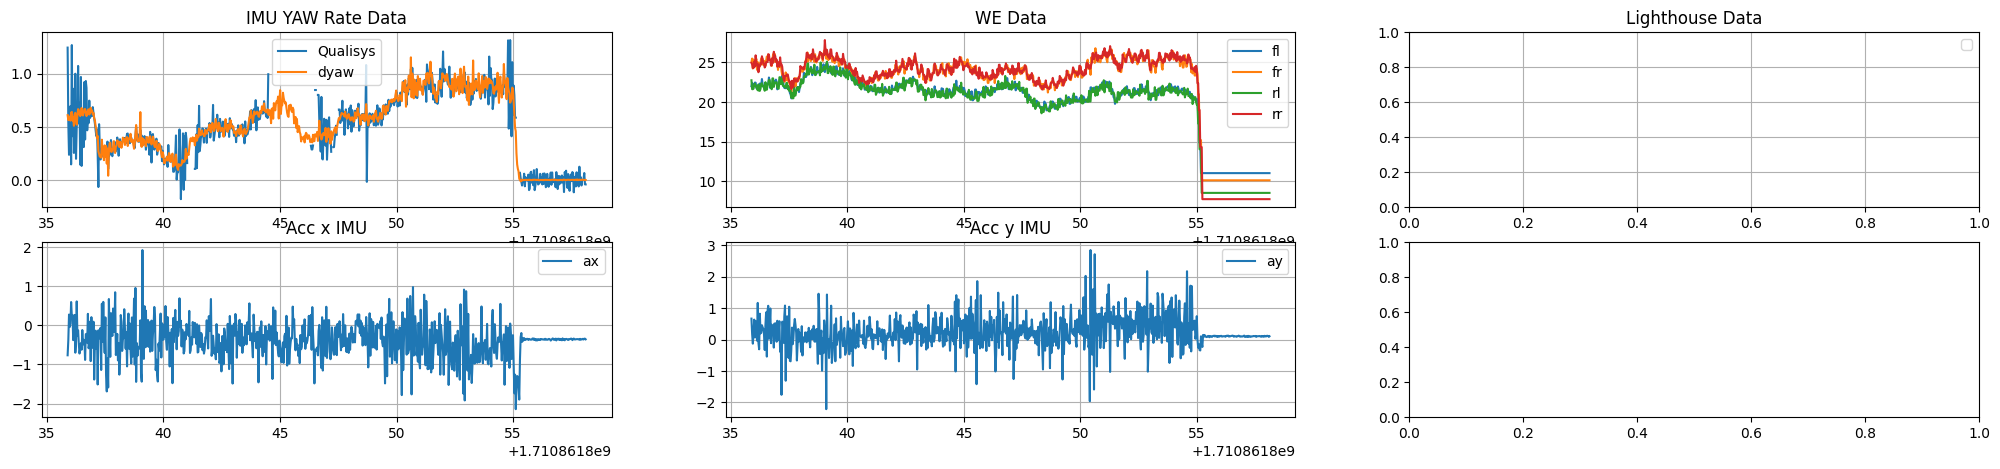

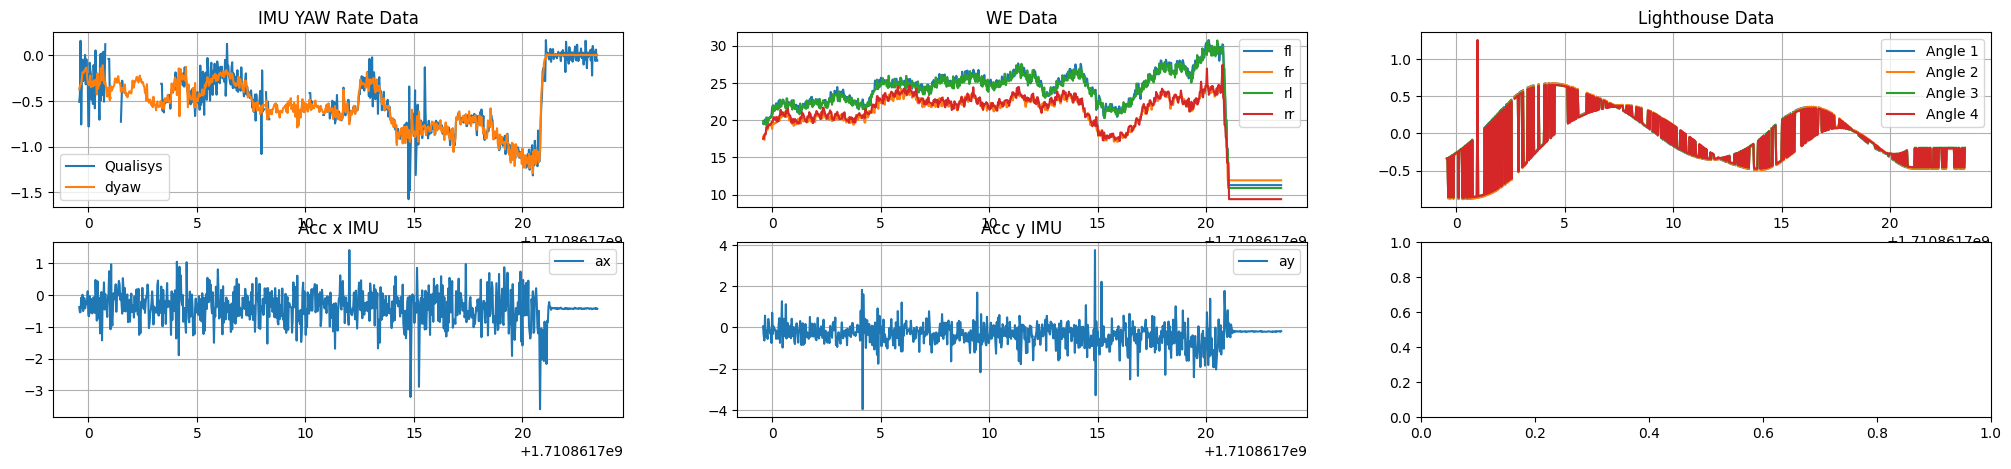

In [8]:
start_ts = 0
end_ts = 8000
starting_bag_at_ts = 9

for idx, bag in enumerate(bags):
    fig, ax = plt.subplots(2,3)
    fig.set_figheight(5)
    fig.set_figwidth(25)
    
    df_name_vel = f'df_{bag_names[idx]}_vel'
    df_name_lh = f'df_{bag_names[idx]}_lh'
    df_name_imu = f'df_{bag_names[idx]}_imu'
    df_name_we = f'df_{bag_names[idx]}_we'

    if df_subsampled[df_name_vel] is not None:
        df_bag_vel = df_subsampled[df_name_vel]
        df_bag_vel_ = df_bag_vel[df_bag_vel['Time'] >= df_bag_vel['Time'].min() + starting_bag_at_ts]
        
    if df_subsampled[df_name_lh] is not None:
        df_bag_lh = df_subsampled[df_name_lh]
        df_bag_lh_ = df_bag_lh[df_bag_lh['Time'] >= df_bag_lh['Time'].min() + starting_bag_at_ts]

    if df_subsampled[df_name_imu] is not None:
        df_bag_imu = df_subsampled[df_name_imu]
        df_bag_imu_ = df_bag_imu[df_bag_imu['Time'] >= df_bag_imu['Time'].min() + starting_bag_at_ts]

    if df_subsampled[df_name_we] is not None:
        df_bag_we = df_subsampled[df_name_we]
        df_bag_we_ = df_bag_we[df_bag_we['Time'] >= df_bag_we['Time'].min() + starting_bag_at_ts]
    

    if  (df_subsampled[df_name_vel] is not None) and (df_subsampled[df_name_imu] is not None):
        ax[0, 0].plot(df_bag_vel_['Time'][start_ts:end_ts], df_bag_vel_['twist.angular.z'][start_ts:end_ts], label = "Qualisys")
        ax[0, 0].plot(df_bag_imu_['Time'][start_ts:end_ts], df_bag_imu_['angular_velocity.z'][start_ts:end_ts], label = "dyaw") 
    ax[0, 0].title.set_text('IMU YAW Rate Data')
    ax[0, 0].legend()
    ax[0, 0].grid()

    if  df_subsampled[df_name_we] is not None:
        ax[0, 1].plot(df_bag_we_['Time'][start_ts:end_ts], df_bag_we_['front_left'][start_ts:end_ts], label = "fl") 
        ax[0, 1].plot(df_bag_we_['Time'][start_ts:end_ts], df_bag_we_['front_right'][start_ts:end_ts], label = "fr") 
        ax[0, 1].plot(df_bag_we_['Time'][start_ts:end_ts], df_bag_we_['rear_left'][start_ts:end_ts], label = "rl") 
        ax[0, 1].plot(df_bag_we_['Time'][start_ts:end_ts], df_bag_we_['rear_right'][start_ts:end_ts], label = "rr") 
    ax[0, 1].title.set_text('WE Data')
    ax[0, 1].legend()
    ax[0, 1].grid()

    if  df_subsampled[df_name_lh] is not None:
        ax[0, 2].plot(df_bag_lh_['Time'][start_ts:end_ts], df_bag_lh_['angle_0'][start_ts:end_ts], label = "Angle 1") 
        ax[0, 2].plot(df_bag_lh_['Time'][start_ts:end_ts], df_bag_lh_['angle_1'][start_ts:end_ts], label = "Angle 2") 
        ax[0, 2].plot(df_bag_lh_['Time'][start_ts:end_ts], df_bag_lh_['angle_2'][start_ts:end_ts], label = "Angle 3") 
        ax[0, 2].plot(df_bag_lh_['Time'][start_ts:end_ts], df_bag_lh_['angle_3'][start_ts:end_ts], label = "Angle 4") 
    ax[0, 2].title.set_text('Lighthouse Data')
    ax[0, 2].legend()
    ax[0, 2].grid()

    if  df_subsampled[df_name_imu] is not None:
        ax[1, 0].plot(df_bag_imu_['Time'][start_ts:end_ts], df_bag_imu_['linear_acceleration.x'][start_ts:end_ts], label = "ax") 
    ax[1, 0].title.set_text('Acc x IMU')
    ax[1, 0].legend()
    ax[1, 0].grid()

    if  df_subsampled[df_name_imu] is not None:
        ax[1, 1].plot(df_bag_imu_['Time'][start_ts:end_ts], df_bag_imu_['linear_acceleration.y'][start_ts:end_ts], label = "ay") 
    ax[1, 1].title.set_text('Acc y IMU')
    ax[1, 1].legend()
    ax[1, 1].grid()